# Coastal Kelvin Wave Test Case

simulating a coastal kelvin wave

In [1]:
CODE_ROOT = pwd() * "/"

"/home/rrs/Desktop/MPAS_Ocean/"

In [56]:
include(CODE_ROOT * "mode_forward.jl")
include(CODE_ROOT * "mode_init.jl")
include(CODE_ROOT * "visualization.jl")


using PyPlot
using PyCall

animation  = pyimport("matplotlib.animation")
ipydisplay = pyimport("IPython.display")


using LinearAlgebra # for norm()

using Printf # for print formatting

In [7]:
myMPAS_O = MPAS_Ocean(false,
                CODE_ROOT * "MPAS_O_Shallow_Water/MPAS_O_Shallow_Water_Mesh_Generation/CoastalKelvinWaveMesh",
                "culled_mesh.nc", "mesh.nc", periodicity="NonPeriodic_x")
ocn_init_routines_compute_max_level!(myMPAS_O)

In [44]:
meanCoriolisParameterf = sum(myMPAS_O.fCell) / myMPAS_O.nCells

0.0001

In [11]:
meanFluidThicknessH = sum(myMPAS_O.bottomDepth)/length(myMPAS_O.bottomDepth)

1000.0

In [46]:
rossbyRadiusR = sqrt(gravity*meanFluidThicknessH)/meanCoriolisParameterf

989949.4936611665

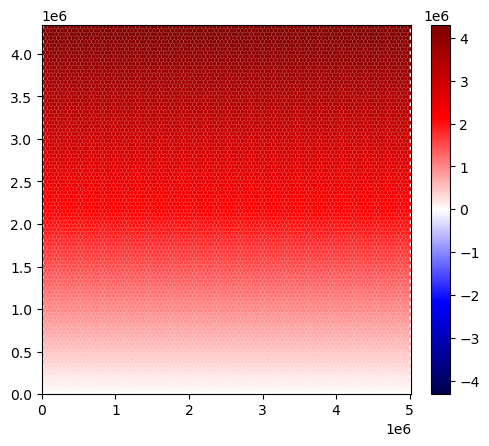

In [14]:
fig, ax, _, _ = heatMapMesh(myMPAS_O, myMPAS_O.yCell)
display(fig)

## the lateral profile of the kelvin wave, can be any function

In [200]:
function lateralProfileF(y)
    mu = myMPAS_O.lY/2#20.0e5
    sigma = 4.0e5
    return 1e-3*exp(- (y .% myMPAS_O.lY -mu)^2 / sigma^2) #* cos(y*5.0e-6)
end

lateralProfileF (generic function with 1 method)

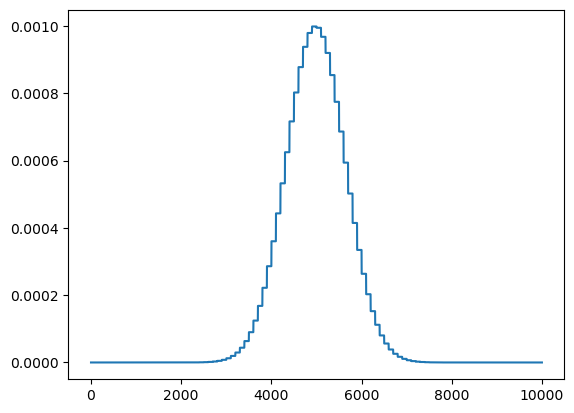

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f1866cb4190>

In [175]:
plot(lateralProfileF.(myMPAS_O.yCell))

## set the velocity and ssh to be a kelvin wave

In [184]:
c = sqrt(gravity*meanFluidThicknessH)

98.99494936611666

In [218]:
function kelvinWaveExactNormalVelocity(myMPAS_O, iEdge, t=0)
    v = sqrt(gravity*meanFluidThicknessH) * lateralProfileF(myMPAS_O.yEdge[iEdge] .+ c*t) * exp(-myMPAS_O.xEdge[iEdge]/rossbyRadiusR)
    return v*sin(myMPAS_O.angleEdge[iEdge])
end

kelvinWaveExactNormalVelocity (generic function with 2 methods)

In [219]:
function kelvinWaveExactSSH(myMPAS_O, iCell, t=0)
    return - meanFluidThicknessH * lateralProfileF(myMPAS_O.yCell[iCell] .+ c*t) * exp(-myMPAS_O.xCell[iCell]/rossbyRadiusR)
end

kelvinWaveExactSSH (generic function with 2 methods)

In [220]:
function kelvinWaveExactSolution!(myMPAS_O, t=0)
    for iCell in 1:myMPAS_O.nCells
        myMPAS_O.sshCurrent[iCell] = kelvinWaveExactSSH(myMPAS_O, iCell)
    end
    
    for iEdge in 1:myMPAS_O.nEdges
        myMPAS_O.normalVelocityCurrent[iEdge] = kelvinWaveExactNormalVelocity(myMPAS_O, iEdge)
    end
end

kelvinWaveExactSolution! (generic function with 2 methods)

In [221]:
kelvinWaveExactSolution!(myMPAS_O)

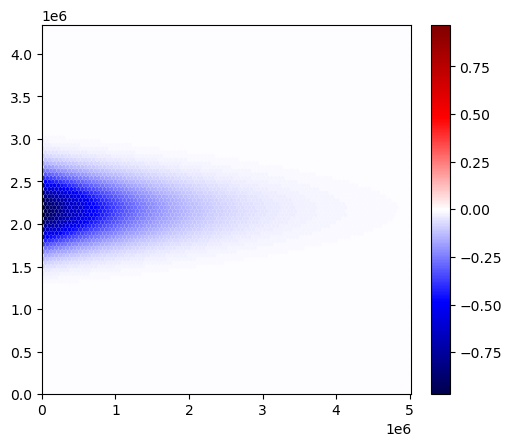

In [222]:
fig, ax, _, _ = heatMapMesh(myMPAS_O, myMPAS_O.sshCurrent)
display(fig)

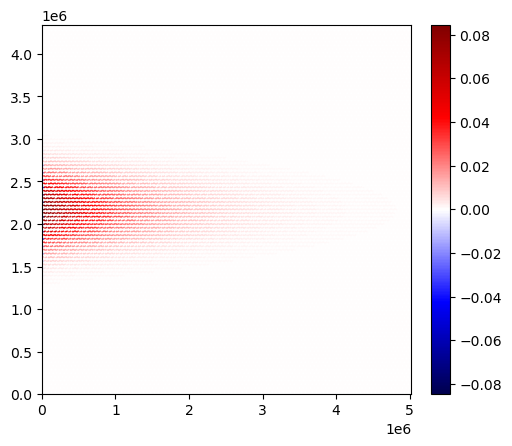

In [179]:
fig, ax, _, = edgeHeatMapMesh(myMPAS_O, myMPAS_O.normalVelocityCurrent)
display(fig)

## define dt based on cfl condition

In [296]:
dt = 0.1*minimum(myMPAS_O.dcEdge) / sqrt(gravity*meanFluidThicknessH)

50.50762722760972

In [294]:
myMPAS_O.myNamelist.config_dt

180.0

# Simulate wave

In [333]:
function boundaryCondition!(myMPAS_O, t)
    for iEdge in 1:myMPAS_O.nEdges
        if myMPAS_O.boundaryEdge[iEdge] == 1.0
            myMPAS_O.normalVelocityNew[iEdge] = kelvinWaveExactNormalVelocity(myMPAS_O, iEdge, t+dt)
        end
    end
    
#     for iCell in 1:myMPAS_O.nCells
#         if myMPAS_O.boundaryCell[iCell] == 1.0
#             myMPAS_O.sshCurrent[iCell] = kelvinWaveExactSSH(myMPAS_O, iCell, t)
#         end
#     end
end

boundaryCondition! (generic function with 2 methods)

In [334]:
include("mode_forward.jl")

forwardBackwardStep! (generic function with 1 method)

In [335]:
kelvinWaveExactSolution!(myMPAS_O)

In [336]:
nFrames = 20

sshOverTime = zeros(Float64, (nFrames, myMPAS_O.nCells))

t = 0

for i in 1:nFrames
    for j in 1:10
#         forwardBackwardSingleStep!(myMPAS_O, dt)myMPAS_O.normalVelocityNew = myMPAS_O.normalVelocityCurrent + dt*ComputeNormalVelocityTendency(myMPAS_O, myMPAS_O.normalVelocityCurrent, myMPAS_O.sshCurrent)
        myMPAS_O.normalVelocityNew = myMPAS_O.normalVelocityCurrent + dt*ComputeNormalVelocityTendency(myMPAS_O, myMPAS_O.normalVelocityCurrent, myMPAS_O.sshCurrent)
        
        boundaryCondition!(myMPAS_O, t)

        myMPAS_O.sshNew = myMPAS_O.sshCurrent + dt*ComputeSSHTendency(myMPAS_O, myMPAS_O.normalVelocityNew, myMPAS_O.sshCurrent)

        myMPAS_O.normalVelocityCurrent[:] = myMPAS_O.normalVelocityNew[:]
        myMPAS_O.sshCurrent[:] = myMPAS_O.sshNew[:]
        t += dt
    end
    sshOverTime[i,:] .= myMPAS_O.sshCurrent[:]
end

## animate simulation

In [337]:
cMax = maximum(abs.(sshOverTime))

fig, ax, _, col = heatMapMesh(myMPAS_O, sshOverTime[1,:], cMin=-cMax, cMax=cMax)

function nextFrame(i)
    col.set_array(sshOverTime[i+1,:])
end

anim = animation.FuncAnimation(fig, nextFrame, frames=nFrames)

PyObject <matplotlib.animation.FuncAnimation object at 0x7f18200fd580>

In [338]:
ipydisplay.HTML(anim.to_html5_video())

PyObject <IPython.core.display.HTML object>

In [205]:
nFrames = 50

sshOverTime = zeros(Float64, (nFrames, myMPAS_O.nCells))

t = 0

for i in 1:nFrames
    t += 10*dt
    kelvinWaveExactSolution!(myMPAS_O, t)
    sshOverTime[i,:] .= myMPAS_O.sshCurrent[:]
end

## animate simulation

In [206]:
cMax = maximum(abs.(sshOverTime))

fig, ax, _, col = heatMapMesh(myMPAS_O, sshOverTime[1,:], cMin=-cMax, cMax=cMax)

function nextFrame(i)
    col.set_array(sshOverTime[i+1,:])
end

anim = animation.FuncAnimation(fig, nextFrame, frames=nFrames)

PyObject <matplotlib.animation.FuncAnimation object at 0x7f1864fd9610>

In [207]:
ipydisplay.HTML(anim.to_html5_video())

PyObject <IPython.core.display.HTML object>

## repeat simulation with zero coriolis force

In [147]:
kelvinWaveInitialCondition!(myMPAS_O)
myMPAS_O.fCell .= 0
myMPAS_O.fVertex .= 0
myMPAS_O.fEdge .= 0


30200-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [148]:
nFrames = 100

sshOverTime = zeros(Float64, (nFrames, myMPAS_O.nCells))

for i in 1:nFrames
    forwardBackward!(myMPAS_O, dt, dt*10)
    sshOverTime[i,:] .= myMPAS_O.sshCurrent[:]
end

In [149]:
cMax = maximum(abs.(sshOverTime))

fig, ax, _, col = heatMapMesh(myMPAS_O, sshOverTime[1,:], cMin=-cMax, cMax=cMax)

function nextFrame(i)
    col.set_array(sshOverTime[i+1,:])
end

anim = animation.FuncAnimation(fig, nextFrame, frames=nFrames)

PyObject <matplotlib.animation.FuncAnimation object at 0x7f1863f3f430>

In [150]:
ipydisplay.HTML(anim.to_html5_video())

PyObject <IPython.core.display.HTML object>